## Importing All Required Libraries

In [1]:
!pip install keras_tuner
!pip install pytz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import time
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline
import pytz

## Importing Dataset i.e. GOOGLE (GOOGL) Stock Price Dataset

In [3]:
end_date = datetime.now(pytz.UTC).strftime('%Y-%m-%d')
df = yf.download('GOOGL', start='2004-08-19', end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2004-08-19,2.501941,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20,2.700670,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23,2.727849,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24,2.614895,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25,2.643072,2.652653,2.702703,2.599600,2.626627,183772044


In [5]:
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2024-12-26,195.600006,195.600006,196.750000,194.380005,195.149994,12046600
2024-12-27,192.759995,192.759995,195.320007,190.649994,194.949997,18891400
2024-12-30,191.240005,191.240005,192.550003,189.119995,189.800003,14264700
2024-12-31,189.300003,189.300003,191.960007,188.509995,191.080002,17466900
2025-01-02,189.429993,189.429993,192.000000,187.500000,190.649994,20339500


### Dropping the multilevel columns names

In [6]:
df.columns = df.columns.get_level_values(0)

In [7]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2004-08-19,2.501941,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20,2.700670,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23,2.727849,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24,2.614895,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25,2.643072,2.652653,2.702703,2.599600,2.626627,183772044
...,...,...,...,...,...,...
2024-12-26,195.600006,195.600006,196.750000,194.380005,195.149994,12046600
2024-12-27,192.759995,192.759995,195.320007,190.649994,194.949997,18891400
2024-12-30,191.240005,191.240005,192.550003,189.119995,189.800003,14264700


In [8]:
df.duplicated().sum()

0

## Copying the dataset for future use

In [9]:
df1 = df.copy()
df1.reset_index(inplace=True)

In [10]:
df.reset_index(drop=True, inplace=True)

### Dropping unwanted column

In [11]:
df.drop(['Adj Close'], axis=1, inplace=True)

In [12]:
df

Price,Close,High,Low,Open,Volume
0,2.511011,2.604104,2.401401,2.502503,893181924
1,2.710460,2.729730,2.515015,2.527778,456686856
2,2.737738,2.839840,2.728979,2.771522,365122512
3,2.624374,2.792793,2.591842,2.783784,304946748
4,2.652653,2.702703,2.599600,2.626627,183772044
...,...,...,...,...,...
5123,195.600006,196.750000,194.380005,195.149994,12046600
5124,192.759995,195.320007,190.649994,194.949997,18891400
5125,191.240005,192.550003,189.119995,189.800003,14264700
5126,189.300003,191.960007,188.509995,191.080002,17466900


### Splitting into features and target

In [13]:
features = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

### Scaling the features

In [14]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features (Open, High, Low, Volume)
scaled_features = scaler_features.fit_transform(features)

# Scale the target (Close)
scaled_target = scaler_target.fit_transform(target)

### Convert to DataFrame to maintain indices

In [15]:
# Combine the scaled features and scaled target into a new DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Volume'])
scaled_data['Close'] = scaled_target  # Use the scaled Close values as the target

### Function to create sequences

In [16]:
sequence_length = 30
X = []
y = []
target_index = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[['Open', 'High', 'Low', 'Volume']].values[i-sequence_length:i])
    y.append(scaled_data['Close'].values[i])
    target_index.append(i)  # store index of each target value

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

### Splitting the data into train and test set

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, y_test_indices = train_test_split(target_index, test_size=0.2, random_state=42)

### Model Building using CNN

In [18]:
def build_model(hp):
    model = Sequential()

    # Tune the number of units in each LSTM layer
    filter_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    kernel_size_1 = hp.Choice('kernel_size_1', values=[3, 5, 7])
    pool_size_1 = hp.Choice('pool_size_1', values=[2, 3])
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)

    # Tune dropout rate
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)

    # Tune the dense layer units
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    # Adding CNN layers
    model.add(Conv1D(filters=filter_1,
                     kernel_size=kernel_size_1,
                     activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=pool_size_1))
    model.add(Conv1D(filters=filter_1,
                     kernel_size=kernel_size_1,
                     activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(lstm_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                  hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='mean_squared_error', metrics=['mse', 'mae'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='stock_price_tuning',
    project_name='cnn_lstm_stock_price')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train,
             validation_data=(X_test, y_test),
             epochs=50,
             callbacks=[early_stopping],
             batch_size=32)

Trial 10 Complete [00h 01m 10s]
val_loss: 0.0007168411684688181

Best val_loss So Far: 0.00019540315406629816
Total elapsed time: 00h 24m 05s


In [19]:
best_model = tuner.get_best_models(num_models=1)[0]

In [20]:
# Make predictions on the test set
predictions = best_model.predict(X_test)
predictions.flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


array([0.04555663, 0.05979995, 0.05460744, ..., 0.8863468 , 0.06376315,
       0.34653983], dtype=float32)

In [21]:
y_test

array([0.04419913, 0.06057209, 0.05571163, ..., 0.85872272, 0.06038391,
       0.35627436])

In [22]:
y_pred_inv = scaler_target.inverse_transform(predictions)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [23]:
prediction = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': y_pred_inv.flatten()}, index=y_test_indices)
for a in prediction.index:
    for b in df1.index:
        if a == b:
            prediction['Date'] = df1['Date']
prediction.set_index('Date', inplace=True)
prediction.sort_index(inplace=True)
prediction

,Actual,Predicted
Date,,
2004-10-13,3.526026,3.439246
2004-10-19,3.702202,3.614021
2004-10-26,4.549550,3.952082
2004-10-28,4.837337,4.394997
2004-11-03,4.796547,4.992059
...,...,...
2024-12-12,191.960007,175.622742
2024-12-16,196.660004,180.010605
2024-12-23,194.630005,189.589569


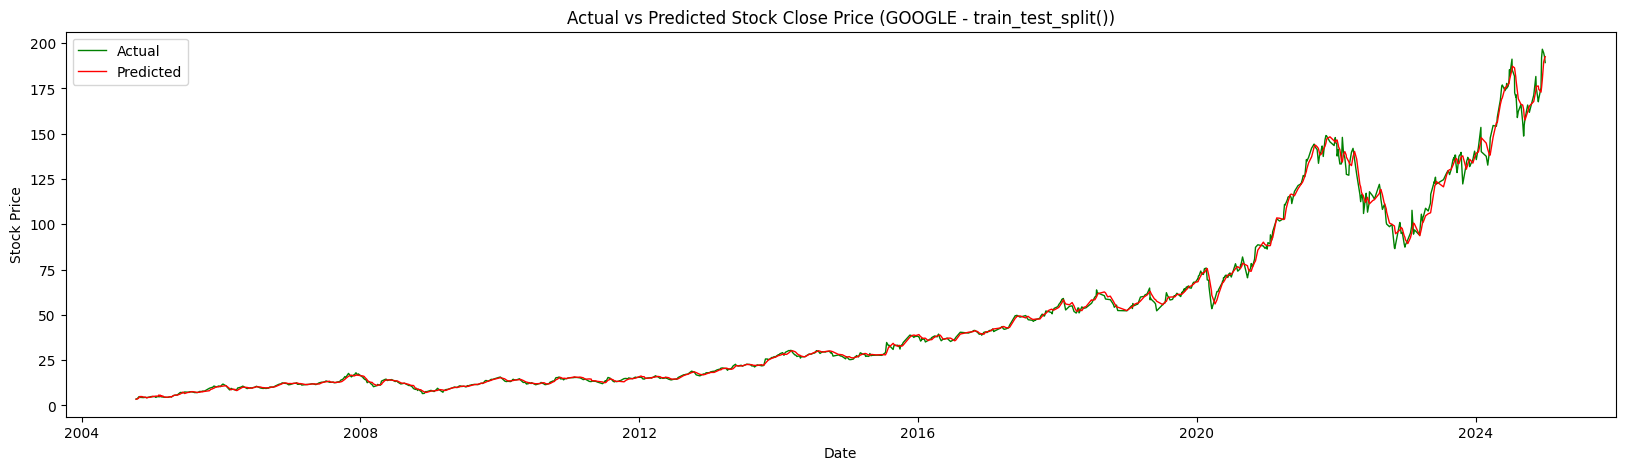

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(prediction.Actual, label='Actual', color='g', linewidth=1)
plt.plot(prediction.Predicted, label='Predicted', color='r', linewidth=1)
plt.title('Actual vs Predicted Stock Close Price (GOOGLE - train_test_split())')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


## Calculating the Performance Evaluation Metrics

In [25]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.00018313524358039578
Root Mean Squared Error: 0.013532747081815864
Mean Absolute Error: 0.007385667729698807


In [26]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 6.903657738611538
Root Mean Squared Error: 2.6274812537126766
Mean Absolute Error: 1.4339810696302677


In [27]:
best_model.save('/content/drive/MyDrive/MSc. Dissertation/Model/built_models/cnnlstm_model_train_test_split.h5')